### Load libraries

In [1]:
import re

import matplotlib.pyplot as plt
import numpy as np

import utils

plt.style.use(
    [
        "tableau-colorblind10",
        utils.get_style("default"),
        utils.get_style("2-col"),
        utils.get_style("small-legend"),
    ]
)

### Figure 5a & 5b

In [2]:
from pathlib import Path
from sgfmill.sgf import Sgf_game


games_file = Path(
    "/nas/ucb/ttseng/go_attack/backup/s545mil-vs-cp505-v4096-20230117/games.sgfs"
)
games = [Sgf_game.from_string(line) for line in games_file.open()]
selfplay_games = [
    Sgf_game.from_string(line)
    for p in Path(
        "/nas/ucb/k8/go-attack/match/ttseng-cp505-v2048-vs-self-20221118-195315"
    ).rglob("*.sgfs")
    for line in p.open()
]

In [3]:
from typing import Optional
import numpy as np
import re


def get_stats_selfplay(games: list, color: str = "w") -> tuple[np.ndarray, np.ndarray]:
    """Return predicted win rates and a mask which is 1 at index i iff `color` won game i."""
    game_lengths = np.array([len(g.get_main_sequence()) - 1 for g in games])
    num_moves = min(game_lengths)

    winrates = np.full((len(games), num_moves), np.nan)
    wins = np.full(len(games), np.nan)

    # Regex that matches exactly 4 decimal numbers separated by spaces
    probs_regex = re.compile(r"^(\d\.\d+) (\d\.\d+) (\d\.\d+) (-?\d+\.\d+)")
    for i, game in enumerate(games):
        root = game.get_root()
        if not root.has_property("RE"):
            continue

        sequence = game.get_main_sequence()
        sequence.pop(0)  # Remove root node
        sequence = sequence[-num_moves:]

        winner, _ = root.get("RE").split("+")
        wins[i] = winner.lower() == color

        for j, node in enumerate(sequence):
            cur_color, _ = node.get_move()
            if cur_color.lower() != color:
                continue

            comment = node.get("C").strip()
            assert comment

            maybe_match = probs_regex.match(comment)
            assert maybe_match

            # These are all from white's perspective
            win, loss, _, score = map(float, maybe_match.groups())
            if color == "b":
                win, loss = loss, win
                score = -score

            # Winrate probabilities in KataGo are logged up to the 2nd decimal place,
            # so we clip them to [0.01, 0.99] to avoid numerical issues in the BCE
            # calculation
            winrates[i, j] = np.clip(win, 0.01, 0.99)

    return winrates, wins

In [4]:
black_winrates, black_wins = get_stats_selfplay(selfplay_games, color="b")
white_winrates, white_wins = get_stats_selfplay(selfplay_games, color="w")
white_loss = -(
    white_wins[:, None] * np.log(white_winrates)
    + (1 - white_wins[:, None]) * np.log(1 - white_winrates)
)
black_loss = -(
    black_wins[:, None] * np.log(black_winrates)
    + (1 - black_wins[:, None]) * np.log(1 - black_winrates)
)
selfplay_loss = np.concatenate([white_loss, black_loss])

In [5]:
def get_stats(
    games: list, time_to_end: bool = False
) -> tuple[np.ndarray, np.ndarray, np.ndarray]:
    """Return (`adv_win_rates`, `victim_win_rates`, `adv_wins`) as a tuple.

    `np.nan` is used as a filler for turns after the game ends, or for moves
    where it's not the {adversary,victim}'s turn.

    Args:
        games: A list of sgfmill.Sgf_game objects.
        time_to_end: Whether to align games s.t. they all end at the same time.

    Returns:
        adv_win_rates: A floating point array of the adversary's win rates.
        victim_win_rates: A floating point array of the victim's win rates.
        adv_wins: A 1D boolean array which is True at index i iff the adversary won game i.
    """
    game_lengths = np.array([len(g.get_main_sequence()) - 1 for g in games])
    num_moves = min(game_lengths) if time_to_end else max(game_lengths)

    adv_win_rates = np.full((len(games), num_moves), np.nan)
    victim_win_rates = np.full((len(games), num_moves), np.nan)
    adv_wins = np.full(len(games), np.nan)

    # Regex that matches exactly 4 decimal numbers separated by spaces
    probs_regex = re.compile(r"^(\d\.\d+) (\d\.\d+) (\d\.\d+) (-?\d+\.\d+)")
    for i, game in enumerate(games):
        root = game.get_root()
        if not root.has_property("RE"):
            continue

        black, white = root.get("PB").strip('"'), root.get("PW").strip('"')
        assert "adv" in black or "adv" in white

        adv_color = "b" if "adv" in black else "w"
        sequence = game.get_main_sequence()
        sequence.pop(0)  # Remove root node
        if time_to_end:
            sequence = sequence[-num_moves:]

        winner, _ = root.get("RE").split("+")
        adv_won = winner.lower() == adv_color
        adv_wins[i] = adv_won

        for j, node in enumerate(sequence):
            comment = node.get("C").strip()
            assert comment

            maybe_match = probs_regex.match(comment)
            assert maybe_match

            # These are all from white's perspective
            win, loss, draw, score = map(float, maybe_match.groups())
            if adv_color == "b":
                win, loss = loss, win
                score = -score

            cur_color, _ = node.get_move()
            if cur_color == adv_color:
                # Winrate probabilities in KataGo are logged up to the 2nd decimal place,
                # so we clip them to [0.01, 0.99] to avoid numerical issues in the BCE
                # calculation
                adv_win_rates[i, j] = np.clip(win, 0.01, 0.99)
            else:
                victim_win_rates[i, j] = np.clip(win, 0.01, 0.99)

    return adv_win_rates, victim_win_rates, adv_wins

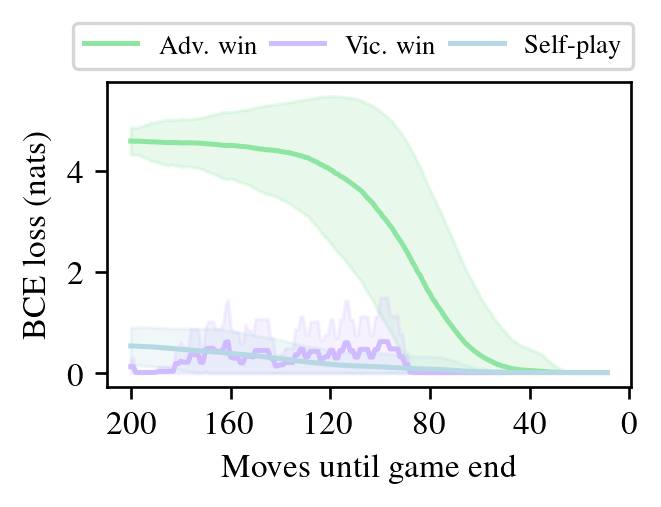

In [6]:
import matplotlib.pyplot as plt


def plot(x, label, color):
    mean_victim_loss = np.nanmean(x, axis=0)
    victim_loss_std = np.nanstd(x, axis=0)

    kernel = np.ones(10) / 10
    smoothed_victim_bce_loss = np.convolve(mean_victim_loss, kernel, mode="valid")
    smoothed_victim_bce_loss_std = np.convolve(victim_loss_std, kernel, mode="valid")

    plt.plot(smoothed_victim_bce_loss, label=label, c=color)
    plt.xlabel("Moves until game end")
    plt.ylabel("BCE loss (nats)")

    plt.fill_between(
        np.arange(len(smoothed_victim_bce_loss)),
        np.clip(
            smoothed_victim_bce_loss - smoothed_victim_bce_loss_std, a_min=0, a_max=None
        ),
        np.clip(
            smoothed_victim_bce_loss + smoothed_victim_bce_loss_std, a_min=0, a_max=None
        ),
        alpha=0.2,
        color=color,
    )


fig = plt.figure()

_, victim_win_rates, gt_adv_wins = get_stats(games, time_to_end=True)
victimplay_loss = -(
    gt_adv_wins[:, None] * np.log(victim_win_rates)
    + (1 - gt_adv_wins[:, None]) * np.log(1 - victim_win_rates)
)
max_moves = min(
    selfplay_loss.shape[1], victimplay_loss.shape[1], 201
)  # 201 moves makes the ticks align nicely

plot(
    victimplay_loss[gt_adv_wins.astype(bool), -max_moves:],
    label="Adv. win",
    color=(0.5529411764705883, 0.8980392156862745, 0.6313725490196078),
)
plot(
    victimplay_loss[~gt_adv_wins.astype(bool), -max_moves:],
    label="Vic. win",
    color=(0.8156862745098039, 0.7333333333333333, 1.0),
)
plot(
    selfplay_loss[:, -max_moves:],
    label="Self-play",
    color=(0.71372549, 0.84313725, 0.89411765),
)

plt.legend(
    loc="lower center",
    bbox_to_anchor=(0.47, 1.0),
    columnspacing=0.5,
    ncol=3,
    fancybox=True,
)
ticks = np.arange(0, max_moves, 40)
plt.xticks(ticks, ticks[::-1])

plt.savefig("winrate-avg.pgf", backend="pgf")

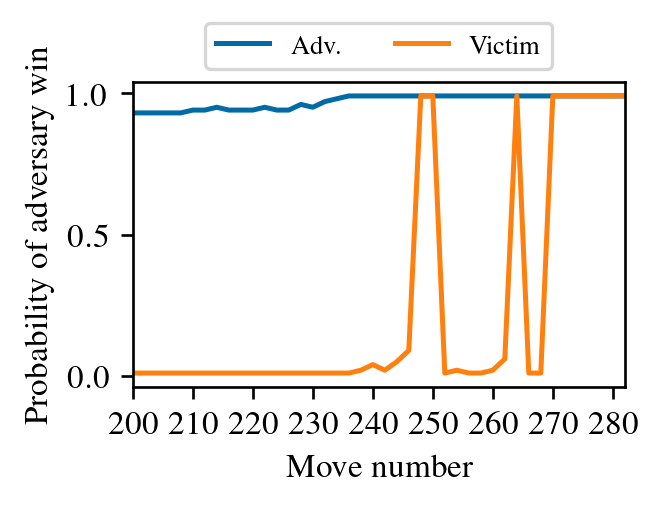

In [7]:
fig5b_game = Sgf_game.from_string(games_file.open().readlines()[876])
adv_win_rates, victim_win_rates, adv_wins = get_stats([fig5b_game])
adv_trunc = adv_win_rates[0, ::2]
victim_trunc = victim_win_rates[0, 1::2]

move_lower_limit = 200
move_upper_limit = 282
move_tick_interval = 10

plt.figure()
plt.plot(adv_trunc, label="Adv.")
plt.plot(victim_trunc, label="Victim")
plt.xticks(
    np.arange(move_lower_limit, move_upper_limit, move_tick_interval) // 2,
    np.arange(move_lower_limit, move_upper_limit, move_tick_interval),
)
plt.xlim(move_lower_limit // 2, move_upper_limit // 2)

plt.legend(loc="lower center", bbox_to_anchor=(0.5, 1.0), ncol=2, fancybox=True)
plt.xlabel("Move number")
plt.ylabel("Probability of adversary win")

plt.savefig("winrate-sample.pgf", backend="pgf")